In [1]:
# Import some libraries
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import os
import random
import shutil
from time import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
#Define hyperparameters
global logs, best_acc
logs = []
best_acc = 0 
modellr = 1e-5
BATCH_SIZE = 8
EPOCHS = 50
number_class = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Divide training, validation, and testing sets by 70%, 15%, and 15%
random.seed(66)

def moveFile(input_path, rate, output_path):
    pathDir = os.listdir(input_path)  #Retrieve the original path of the image
    filenumber = len(pathDir)  #Number of original files
    picknumber = int(filenumber * rate)  #Take a certain number of images from the folder according to the rate ratio
    sample = random.sample(pathDir, picknumber)  #Randomly select sample images with a number of picknumbers
    for file_name in sample:
        shutil.move(input_path +'/'+ file_name, output_path + '/' + file_name)


root = 'datasets'
categories = os.listdir(root+'/train')
np.savetxt(root+'/classes.txt', categories, fmt='%s')
for m in categories:
    #The input path is/train/0 in the root directory, and/train/1 in the root directory
    input_path = root + '/train/' + str(m)
    output_path1 = root + '/val/' + str(m)
    output_path2 = root + '/test/' + str(m)
   #Verify if the output path exists, if not, create it
    isExists = os.path.exists(output_path1)
    if not isExists:
        os.makedirs(output_path1)
        moveFile(input_path, 0.3, output_path1)
    isExists = os.path.exists(output_path2)
    if not isExists:
        os.makedirs(output_path2)
        moveFile(output_path1, 0.3, output_path2)

In [4]:
#Define data augmentation
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(), #Random horizontal flip
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1/255, 1/255, 1/255])])
transform_val = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1/255, 1/255, 1/255])])

In [5]:
#Load training, validation, and test sets
dataset_train = datasets.ImageFolder('datasets/train', transform)
dataset_val = datasets.ImageFolder('datasets/val', transform_val)
dataset_test = datasets.ImageFolder('datasets/test', transform_val)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResBlock, self).__init__()
        #This defines two consecutive convolutional layers within the residual block
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            #shortcut，in order to match the result structure of the two convolutional layers, it needs to be processed here
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        #Add the output of two convolutional layers to the processed x to implement the basic structure of ResNet
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x) 
    
class SA_ResNet(nn.Module):
    def __init__(self, ResBlock, num_classes=5):
        super(SA_ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(ResBlock, 512, 2, stride=2)   

        self.sa1 = SpatialAttention()
        
        self.fc = nn.Linear(512, num_classes)
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.sa1(out) * out
        
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    
class CA_ResNet(nn.Module):
    def __init__(self, ResBlock, num_classes=5):
        super(CA_ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(ResBlock, 512, 2, stride=2)   

        self.ca1 = ChannelAttention(512)
        
        self.fc = nn.Linear(512, num_classes)
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.ca1(out) * out
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


class ensemble_model(nn.Module):
    def __init__(self):
        super(ensemble_model, self).__init__()
        self.model1 = CA_ResNet(ResBlock)
        self.model2 = SA_ResNet(ResBlock)
        
    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        out = out1+out2 
        return out
        
model = ensemble_model()
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=modellr)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    modellrnew = modellr * (0.1 ** (epoch // 50))
    for param_group in optimizer.param_groups:
        param_group['lr'] = modellrnew

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    sum_loss = 0
    total_num = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print_loss = loss.data.item()
        sum_loss += print_loss
        if (batch_idx + 1) % 5 == 0:
            log = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                (batch_idx + 1) * len(data),
                len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item())
            print(log)
            logs.append(log)
    ave_loss = sum_loss / len(train_loader)
    log = 'epoch:{},loss:{}'.format(epoch, ave_loss)
    print(log)
    logs.append(log)

def val(model, device, test_loader, phase):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total_num = len(test_loader.dataset)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            output = model(data)
            loss = criterion(output, target)
            _, pred = torch.max(output.data, 1)
            correct += torch.sum(pred == target)
            print_loss = loss.data.item()
            test_loss += print_loss
        correct = correct.data.item()
        acc = correct / total_num
        avgloss = test_loss / len(test_loader)
        if phase == 'train':
            log = 'Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                avgloss,
                correct,
                len(test_loader.dataset),
                100 * acc)
        else:
            log = 'Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                avgloss,
                correct,
                len(test_loader.dataset),
                100 * acc)
            if acc > best_acc:
                best_acc = acc
                torch.save(model, 'model_best.pth')
        print(log)
        logs.append(log)
        np.savetxt('logs.txt', logs, fmt='%s')

In [8]:
start_time = time()
for epoch in range(1, EPOCHS + 1):
    adjust_learning_rate(optimizer, epoch)
    train(model, DEVICE, train_loader, optimizer, epoch)
    val(model, DEVICE, train_loader, 'train')
    val(model, DEVICE, test_loader, 'val')
torch.save(model, 'model_last.pth')
np.savetxt('logs.txt', logs, fmt='%s')
end_time = time()
print(f'training_time:{end_time-start_time}')

Train Epoch: 1 [40/2566 (2%)]	Loss: 1.507423
Train Epoch: 1 [80/2566 (3%)]	Loss: 1.504002
Train Epoch: 1 [120/2566 (5%)]	Loss: 1.591035
Train Epoch: 1 [160/2566 (6%)]	Loss: 1.258470
Train Epoch: 1 [200/2566 (8%)]	Loss: 1.126681
Train Epoch: 1 [240/2566 (9%)]	Loss: 1.109025
Train Epoch: 1 [280/2566 (11%)]	Loss: 1.226363
Train Epoch: 1 [320/2566 (12%)]	Loss: 1.071216
Train Epoch: 1 [360/2566 (14%)]	Loss: 1.012170
Train Epoch: 1 [400/2566 (16%)]	Loss: 0.828345
Train Epoch: 1 [440/2566 (17%)]	Loss: 1.079406
Train Epoch: 1 [480/2566 (19%)]	Loss: 0.717533
Train Epoch: 1 [520/2566 (20%)]	Loss: 0.943379
Train Epoch: 1 [560/2566 (22%)]	Loss: 1.220411
Train Epoch: 1 [600/2566 (23%)]	Loss: 0.911196
Train Epoch: 1 [640/2566 (25%)]	Loss: 1.324490
Train Epoch: 1 [680/2566 (26%)]	Loss: 0.793185
Train Epoch: 1 [720/2566 (28%)]	Loss: 0.841843
Train Epoch: 1 [760/2566 (30%)]	Loss: 1.445873
Train Epoch: 1 [800/2566 (31%)]	Loss: 1.003184
Train Epoch: 1 [840/2566 (33%)]	Loss: 0.953198
Train Epoch: 1 [880/2

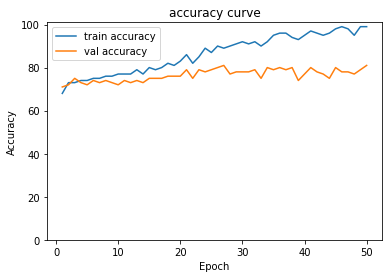

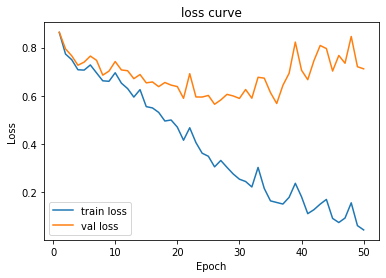

In [9]:
#Visualize loss and accuracy curves
path = 'logs.txt'
with open(path, 'r') as f:
    lines = f.readlines()
    
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for line in lines:
    if 'Val set' in line:
        line = line.split(',')
        val_acc.append(float(line[-1].split('(')[-1].split('%')[0]))
        val_loss.append(float(line[0].split(':')[-1]))
    elif 'Train set' in line:
        line = line.split(',')
        train_acc.append(float(line[-1].split('(')[-1].split('%')[0]))
        train_loss.append(float(line[0].split(':')[-1]))
        
x = np.arange(1, len(val_acc)+1)

plt.plot(x, train_acc, label='train accuracy')
plt.legend(loc='best')
plt.plot(x, val_acc, label='val accuracy')
plt.legend(loc='best')
plt.title('accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# #Change the scale range of the vertical axis
plt.ylim(0,101)
plt.show()

plt.plot(x, train_loss, label='train loss')
plt.legend(loc='best')
plt.plot(x, val_loss, label='val loss')
plt.legend(loc='best')
plt.title('loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

准确率：0.8103975535168195
混淆矩阵: 
[[ 17  13   2   1   0]
 [ 11  68   4   3   3]
 [  2   1 159   0   0]
 [  1  11   0  14   0]
 [  0   5   0   5   7]]
每一类的precision、recall和f1-score: 
                 precision    recall  f1-score   support

          Mild
       0.55      0.52      0.53        33
      Moderate
       0.69      0.76      0.73        89
         No_DR
       0.96      0.98      0.97       162
Proliferate_DR
       0.61      0.54      0.57        26
        Severe
       0.70      0.41      0.52        17

       accuracy                           0.81       327
      macro avg       0.70      0.64      0.66       327
   weighted avg       0.81      0.81      0.81       327



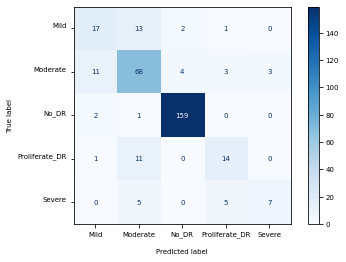

In [10]:
# Test
with open('datasets/classes.txt', 'r') as f:
    classesname = tuple(f.readlines())
model = torch.load('model_last.pth', map_location=DEVICE.type)
model.to(DEVICE)
model.eval()
correct = 0
total_num = len(test_loader.dataset)
labels = []
preds = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = Variable(data).to(DEVICE), Variable(target).to(DEVICE)
        output = model(data)
        _, pred = torch.max(output.data, 1)
        labels.append(target.view(-1))
        preds.append(pred.view(-1))
        correct += torch.sum(pred == target)
    correct = correct.data.item()
    acc = correct / total_num
    print('Accuracy：{}'.format(acc))
    labels = torch.cat(labels)
    preds = torch.cat(preds)
    if 'cuda' in DEVICE.type:
        preds = np.array(preds.cpu())
        labels = np.array(labels.cpu())
    cm = confusion_matrix(labels, preds)
    # Print confusion_matrix
    print("confusion_matrix: ")
    print(cm)
    print("For each category:precision、recall and f1-score: ")
    print(classification_report(labels, preds, target_names=classesname))
    # Draw the confusion matrix
    # ConfusionMatrixDisplay Required parameters: confusion_matrix, display_labels
    plt.rcParams.update({'font.size': 7})
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesname)
    disp.plot(cmap='Blues')
    plt.show()